In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
features = []
with open('data/features', 'rb') as f:
    features = np.load(f)

In [5]:
labels = []

with open('data/train_labels', 'rb') as f:
    labels = np.load(f)

In [9]:
X = pd.DataFrame(features)
y = pd.Series(labels)

**Случайный лес**

Его трудно переобучить и он хорошо справляется с нахождением нелинейных зависимостей. Часто он не сильно уступает в качестве сложным нейронным сетям. Помимо этого, уже обученный лес очень быстро делает предсказания.

Воспользуемся готовой реализацией от sklearn. Необходимо подобрать оптимальные гиперпараметры - это в первую очередь max_depth каждого дерева и n_estimators - количество деревьев

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [16]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [50, 100, 150, 200, 350, 400]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 41.74% with 350 trees


Text(0.5, 0, 'N_estimators')

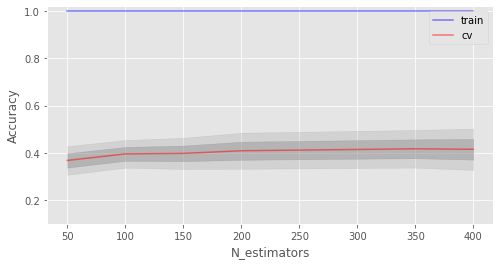

In [19]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Утверждается, что оптимальное значение в сетке поиска - 350. Можно было бы перебрать больше значений в районе 350, но видно, что после 200 accuracy выходит на плато, так что можно не исследовать дальше

In [20]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1, oob_score=True, 
                                 max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 41.81% with 17 max_depth


Text(0.5, 0, 'Max_depth')

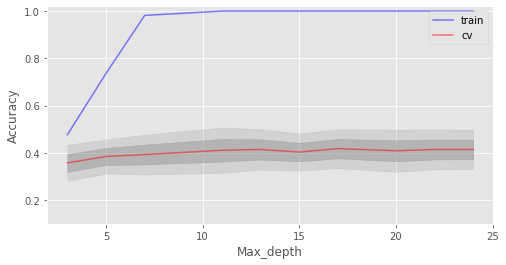

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

С max_depth аналогичная ситуация. После 10 модель выходит на плато. Оптимальное значение достигается на 17

Итоговая accuracy - 41,8%. Это может показаться небольшим, но меток классов 8, то есть "подбрасывание монетки" дало бы нам только 12.5%. В других работах на аналогичных данных достигается accuracy в 60% https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

**Градиентный бустинг**

Родственная модель к случайному лесу, но которая как правило всё-таки показывает себя лучше и эффективнее. К ней применим аналогичное исследование

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(warm_start=True, max_depth=5, 
                                 learning_rate=0.1, subsample=1,
                                n_estimators=100)

In [32]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
max_depth_grid = [2, 3, 5, 7]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    clf = GradientBoostingClassifier(warm_start=True, max_depth=max_depth, 
                                 learning_rate=0.1, n_estimators=50)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)
        
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc)*100, 
                                                        max_depth_grid[np.argmax(test_acc)]))

Best accuracy on CV is 46.85% with 3 max_depth


Text(0.5, 1.0, 'Gradient Boost')

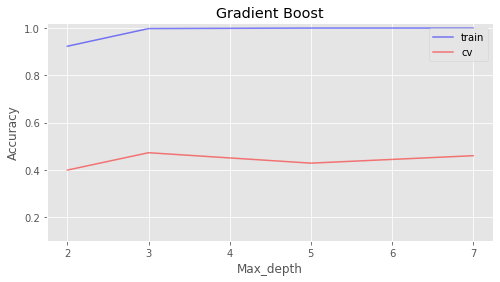

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")
ax.set_title("Gradient Boost")

Видно, что оптимальная max_depth - 3. Её и поставим

In [36]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
trees_grid = [20, 50, 100, 200]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    clf = GradientBoostingClassifier(warm_start=True, max_depth=3, 
                                 learning_rate=0.1, n_estimators=ntrees)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)
        
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc)*100, 
                                                        trees_grid[np.argmax(test_acc)]))

Best accuracy on CV is 47.27% with 50 trees


Text(0.5, 1.0, 'Gradient Boost')

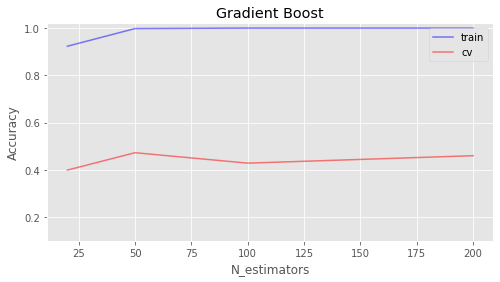

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")
ax.set_title("Gradient Boost")

Есть существенное улучшение качества модели при N_estimators=50 и постепенное улучшение ближе к 200. При больших вычислительных ресурсах нужно было бы обязательно рассмотреть это дальше, а так же сделать сетку поиска плотнее в районе 50

**Многослойная сеть**

Аналогично проведём поиск по гиперпараметрам. В первую очередь нас интересует размерность скрытых слоёв

In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

X_train, X_test, y_train, y_test = train_test_split(normalize(X), y, test_size=0.33, stratify = y)

mlp = MLPClassifier(max_iter=1000, warm_start=True, solver='lbfgs')

parameter_space = {
    'hidden_layer_sizes': [
        (20, 10), (30, 15), (50, 20), (75, 15), (100, 15), 
        (100, 25), (150, 30)],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/home/artem/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/artem/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/artem/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

GridSearchCV(cv=3,
             estimator=MLPClassifier(learning_rate='adaptive', max_iter=1000,
                                     solver='lbfgs', warm_start=True),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(20, 10), (30, 15), (50, 20),
                                                (75, 15), (100, 15), (100, 25),
                                                (150, 30)]})

In [68]:
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'hidden_layer_sizes': (150, 30)}
0.190 (+/-0.160) for {'hidden_layer_sizes': (20, 10)}
0.199 (+/-0.124) for {'hidden_layer_sizes': (30, 15)}
0.217 (+/-0.185) for {'hidden_layer_sizes': (50, 20)}
0.228 (+/-0.222) for {'hidden_layer_sizes': (75, 15)}
0.138 (+/-0.013) for {'hidden_layer_sizes': (100, 15)}
0.194 (+/-0.169) for {'hidden_layer_sizes': (100, 25)}
0.335 (+/-0.025) for {'hidden_layer_sizes': (150, 30)}


In [69]:
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.40145228215767637


0.3403361344537815

Теперь обучим нашу сеть с этими параметрами на большем числе эпох.

from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(150, 30), 
                    max_iter=3000, warm_start=True)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [75]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.5072614107883817
0.42857142857142855


В перспективе число эпох можно было бы сильно увеличить, но пока градиентный бустинг решает задачу лучше